In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from pathlib import Path
import sys

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

from src.io import load_train, load_test, load_oil, load_holidays, load_stores
from src.preprocessing import add_calendar_features, join_oil, build_holiday_features, join_holidays, join_stores
from src.utils import make_group_lags, make_group_leads, make_group_rolling
from src.models import HybridModel
from src.validation import rmsle, time_train_valid_split
from src.viz import *

## 1. Data Preparation


In [2]:
# --- Load data ---
train = load_train()
test = load_test()

oil = load_oil()
holidays = load_holidays()
stores = load_stores()
stores["store_nbr"] = stores["store_nbr"].astype(str)

HORIZON = 16

print("Train shape:", train.shape)
print("Test shape :", test.shape)

Train shape: (3000888, 2)
Test shape : (28512, 1)


In [3]:
y_wide = (
    train["sales"]
    .unstack(["store_nbr", "family"])
    .sort_index()
)

print("y_wide shape:", y_wide.shape)
print("n series (columns):", y_wide.shape[1])
print("column levels:", y_wide.columns.nlevels, y_wide.columns.names)

y_wide shape: (1684, 1782)
n series (columns): 1782
column levels: 2 ['store_nbr', 'family']


In [4]:
# ------------------------------------------------------------
# DeterministicProcess: trend + Fourier seasonality (global)
# ------------------------------------------------------------

fourier_week = CalendarFourier(freq="W", order=3)

dp = DeterministicProcess(
    index=y_wide.index,
    constant=True,
    order=1,  
    additional_terms=[fourier_week],
    drop=True,
)

X1 = dp.in_sample()


## 2. Logique and Structure

$$
y_{s,f,t} = T_t + S_t + C_{s,f,t} + \varepsilon_{s,f,t}
$$

- **$T_t$**: global trend (slow-moving component)  
- **$S_t$**: global seasonality (weekly/yearly) + holiday effects  
- **$C_{s,f,t}$**: local cycle / autocorrelation (lags, rolling stats) and nonlinear interactions with promotions  
- **$\varepsilon_{s,f,t}$**: remaining noise  



### Hybrid model

1. **Model 1 (linear):** learns deterministic structure  
   $$
   T_t + S_t
   $$
   from time features (*DeterministicProcess + Fourier terms*).

2. **Model 2 (tree model):** learns residual structure using tabular features  
   (lags, promotions, oil, calendar indicators).



We train in **log space** using  
$$
\log(1 + y)
$$
to align with the **RMSLE** metric.


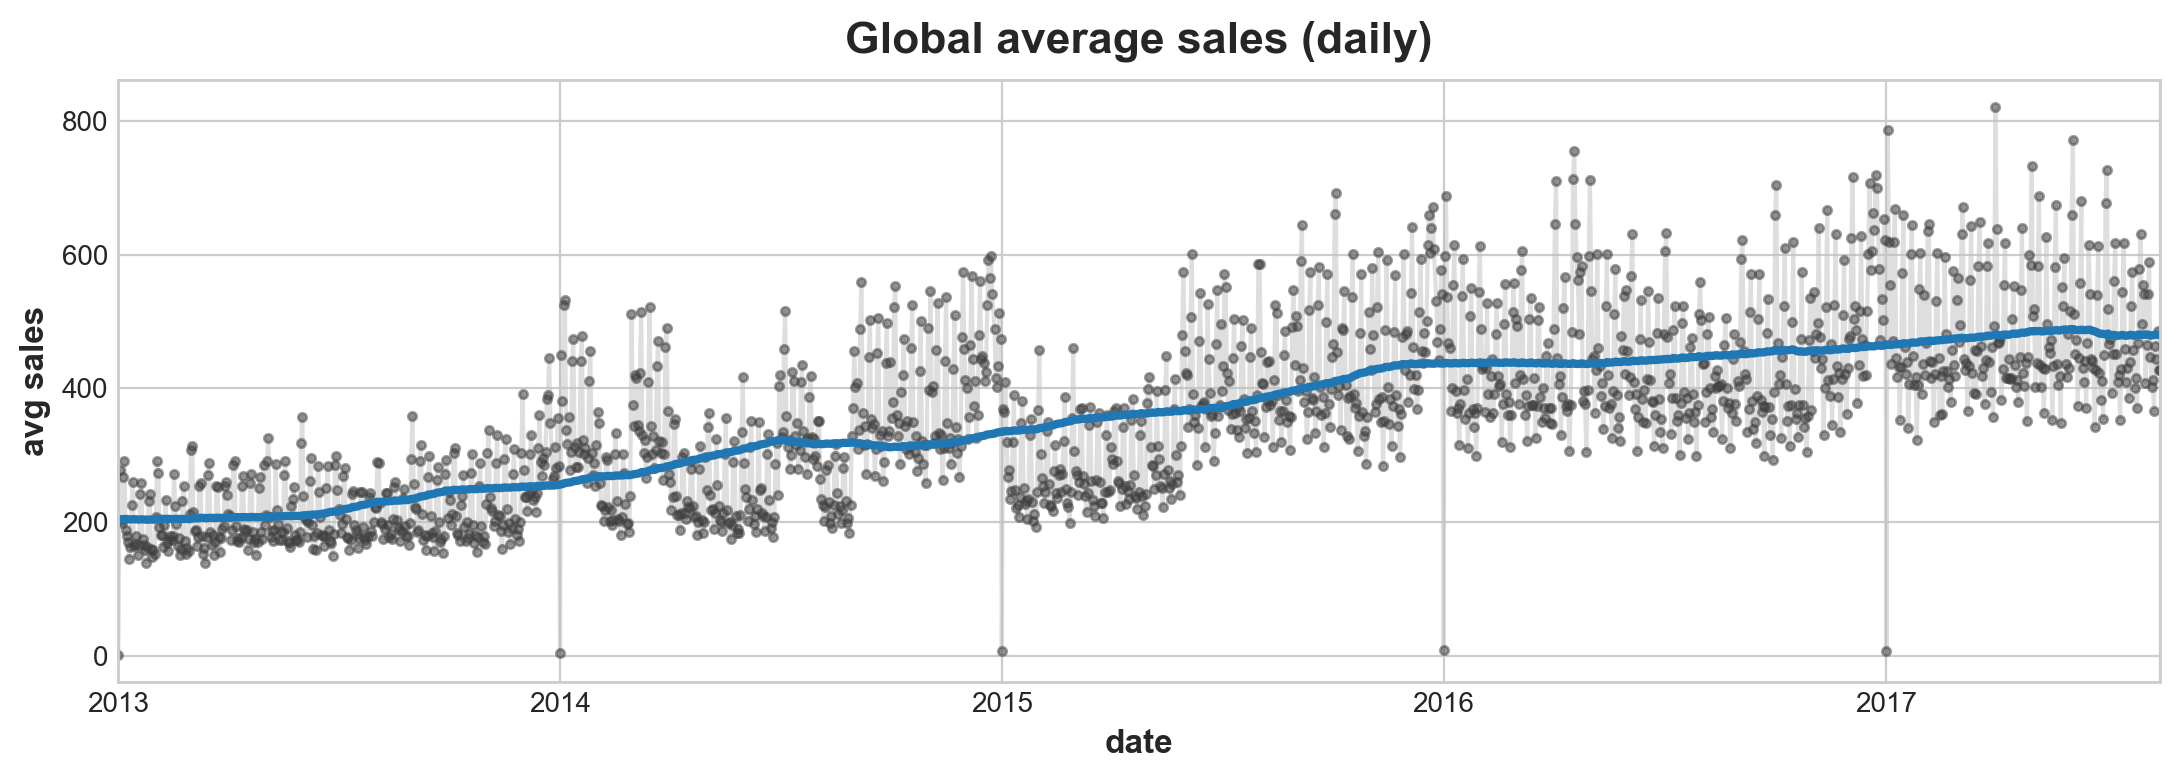

In [5]:
y_global = (
    train["sales"]
    .groupby("date")
    .mean()
    .sort_index()
)

y_global.name = "average_sales"

trend = y_global.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = y_global.plot(**plot_params, alpha=0.5, title="Global average sales (daily)", ylabel= "avg sales")
ax = trend.plot(ax=ax, linewidth=3)

# 3. Design Matrix

In [6]:
y_wide = (
    train["sales"]
    .unstack(["store_nbr", "family"])
    .sort_index()
)

print("y_wide shape:", y_wide.shape)
print("n series (columns):", y_wide.shape[1])
print("column levels:", y_wide.columns.nlevels, y_wide.columns.names)

y_wide shape: (1684, 1782)
n series (columns): 1782
column levels: 2 ['store_nbr', 'family']


In [7]:
# ------------------------------------------------------------
# DeterministicProcess: trend + Fourier seasonality (global)
# ------------------------------------------------------------

fourier_week = CalendarFourier(freq="W", order=3)

dp = DeterministicProcess(
    index=y_wide.index,
    constant=True,
    order=1,  
    additional_terms=[fourier_week],
    drop=True,
)

X1 = dp.in_sample()


In [8]:
# ------------------------------------------------------------
# Base data : oil, holidays dummies, calendar features.
# ------------------------------------------------------------

X2 = train[["onpromotion"]].copy()
X2 = X2.reorder_levels(["date", "store_nbr", "family"]).sort_index()

# Calendar features (ONLY for Model 2)
X2 = add_calendar_features(X2, date_level="date")

# Oil
X2 = join_oil(X2, oil, date_level="date")

# Holidays
dates = X2.index.get_level_values("date")
holiday_feats = build_holiday_features(holidays, start=dates.min(), end=dates.max())
X2 = join_holidays(X2, holiday_feats, date_level="date")

# Stores
X2 = join_stores(X2, stores)

# ------------------------------------------------------------
# Add dynamic features: sales lags + rolling stats + promo dynamics
# ------------------------------------------------------------

# Prepare log-sales series in long format with index (date, store_nbr, family)
y_log_long = np.log1p(train["sales"]).copy()
y_log_long = y_log_long.reorder_levels(["date", "store_nbr", "family"]).sort_index()
y_log_long.name = "ylog"

# Sales lags to capture cycles
X2 = X2.join(make_group_lags(y_log_long, lags=[1,8], name="ylog"))

# Rolling stats to smooth noise
#X2 = X2.join(make_group_rolling(y_log_long, windows=[7], shift=1, name="ylog"))

# Force X2 index to be exactly (date, store_nbr, family) with clean names
#X2 = X2.copy()
#X2 = X2.reorder_levels(["date", "store_nbr", "family"]).sort_index()

# IMPORTANT: reset index names explicitly (fixes duplicated-name corruption)
X2.index = X2.index.set_names(["date", "store_nbr", "family"])


# Promotion dynamics could be known-in-advance exogenous variable.
promo = train["onpromotion"].copy()
promo = promo.reorder_levels(["date", "store_nbr", "family"]).sort_index()
promo.name = "promo"

# promo lags and leads
#X2 = X2.join(make_group_lags(promo, lags=2, name="promo"))
#X2 = X2.join(make_group_leads(promo, leads=3, name="promo"))

# promo rolling / intensity
#X2 = X2.join(make_group_rolling(promo, windows=[7, 14], shift=0, name="promo"))





Text(0.5, 1.0, 'Deseasonalized')

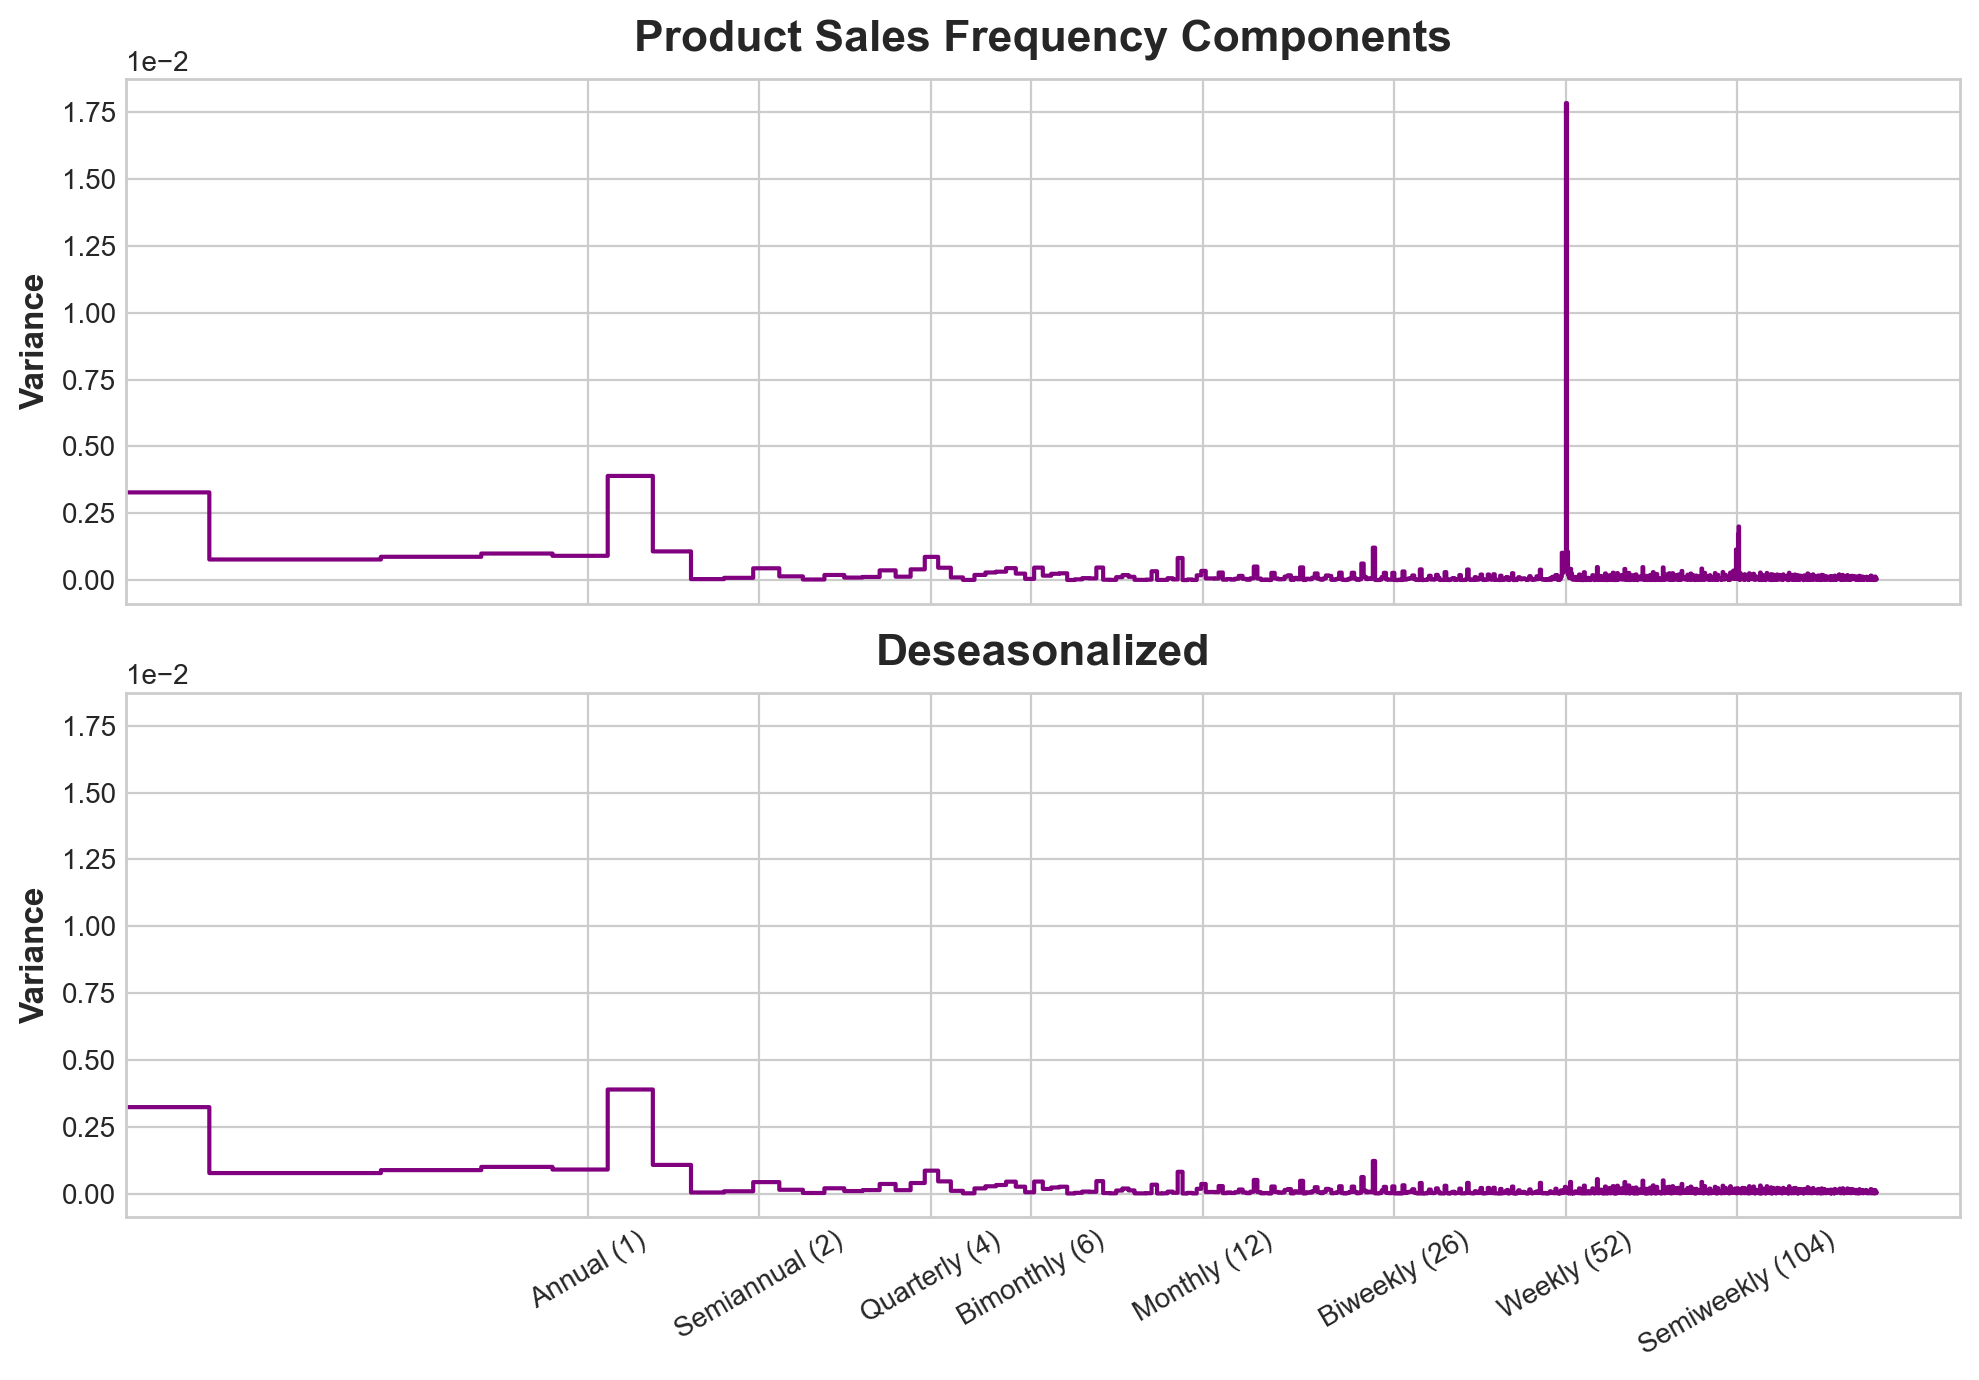

In [9]:
y1 = np.log1p(y_global)  # Linear model: DP owns intercept => fit_intercept=False
det_model = LinearRegression(fit_intercept=False)
det_model.fit(X1, y1)

X1_fore = dp.out_of_sample(steps=HORIZON) 

y1_fit = pd.Series(det_model.predict(X1), index=X1.index, name="fit_log")
y1_fore = pd.Series(det_model.predict(X1_fore), index=X1_fore.index, name="fore_log")

# Convert back to sales scale
y_fit = np.expm1(y1_fit).rename("fit")
y_fore = np.expm1(y1_fore).rename("forecast")

global_residual = (y1 - y1_fit).rename("resid_log")

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y1, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(global_residual, ax=ax2)
ax2.set_title("Deseasonalized")


## 4. Training and Validation Setup

In [10]:
VALID_START = "2017-07-02"

train_mask, valid_mask = time_train_valid_split(y_wide.index, VALID_START)

# initial split
y_train, y_valid = y_wide.loc[train_mask], y_wide.loc[valid_mask]
X1_train, X1_valid = X1.loc[train_mask], X1.loc[valid_mask]

# slice X2 by dates
X2_train = X2.loc[y_train.index]
X2_valid = X2.loc[y_valid.index]

# Use ONLY training period to compute means (no leakage)
enc_train = y_log_long.loc[y_train.index]

global_mean = enc_train.mean()

# Store average
store_avg = enc_train.groupby(level="store_nbr").mean()

# Family average
family_avg = enc_train.groupby(level="family").mean()

# Map into X2
store_idx = X2.index.get_level_values("store_nbr")
family_idx = X2.index.get_level_values("family")


alpha = 20.0  # smoothing strength

store_stats = enc_train.groupby(level="store_nbr").agg(["mean", "count"])
family_stats = enc_train.groupby(level="family").agg(["mean", "count"])

store_smooth = (
    store_stats["mean"] * store_stats["count"] + global_mean * alpha
) / (store_stats["count"] + alpha)

family_smooth = (
    family_stats["mean"] * family_stats["count"] + global_mean * alpha
) / (family_stats["count"] + alpha)

X2["store_avg"] = store_idx.map(store_smooth).astype("float32").fillna(global_mean)
X2["family_avg"] = family_idx.map(family_smooth).astype("float32").fillna(global_mean)


# drop NaNs produced by lags/rolling
X2_train = X2_train.dropna()
X2_valid = X2_valid.dropna()


# IMPORTANT: restrict y and X1 to dates that remain in X2
train_dates = X2_train.index.get_level_values("date").unique().sort_values()
valid_dates = X2_valid.index.get_level_values("date").unique().sort_values()

y_train = y_train.loc[train_dates]
y_valid = y_valid.loc[valid_dates]

X1_train = X1.loc[train_dates]
X1_valid = X1.loc[valid_dates]

print("Train dates:", y_train.index.min(), "→", y_train.index.max(), "|", len(y_train))
print("Valid dates:", y_valid.index.min(), "→", y_valid.index.max(), "|", len(y_valid))
print("X2_train:", X2_train.shape, "X2_valid:", X2_valid.shape)


Train dates: 2013-01-09 → 2017-07-01 | 1631
Valid dates: 2017-07-02 → 2017-08-15 | 45
X2_train: (2906442, 15) X2_valid: (80190, 15)


Fit the model

In [11]:
model1 = LinearRegression(fit_intercept=False)
model2 = LGBMRegressor(
    n_estimators=1000,          
    learning_rate=0.05,        
    num_leaves=31,             
    max_depth=8,               
    min_child_samples=200,     
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1.0,             
    reg_lambda=5.0,           
    random_state=42,
    n_jobs=-1,
)

hybrid = HybridModel(model1=model1, model2=model2, transform="log1p", clip=True)

hybrid.fit(X1=X1_train,X2=X2_train,y_wide=y_train)

y_pred_valid = hybrid.predict(X1_valid, X2_valid)
y_pred_train = hybrid.predict(X1_train, X2_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 2906442, number of used features: 15
[LightGBM] [Info] Start training from score 0.000000


In [12]:
print("Train RMSLE:", rmsle(y_train.loc[y_pred_train.index], y_pred_train))
print("Valid RMSLE:", rmsle(y_valid.loc[y_pred_valid.index], y_pred_valid))

Train RMSLE: 0.6189402779018432
Valid RMSLE: 0.8341555318191812
